In [1]:
import gc
import os
import sys
import itertools
import pickle
from glob import glob
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from transformers import BertConfig, BertTokenizer, BertModel, BertForMaskedLM#, BertLayer, BertEmbeddings
from transformers.modeling_bert import BertLayer, BertEmbeddings

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# re-load functions
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}

In [3]:
DEVICE = 'cuda'

In [4]:
import sys
import pickle
from functools import partial
from glob import glob

import numpy as np
import pandas as pd
import scipy as sp
import torch
from scipy.stats import spearmanr
from tqdm import tqdm

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """

    def __init__(self):
        self.coef_ = 0

    def _spearmanr_loss(self, coef, X, y, labels):
        """
        Get loss according to
        using current coefficients
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                     [np.inf], labels=labels)

        # return -np.mean(spearmanr(y, X_p).correlation)
        return -spearmanr(y, X_p).correlation

    def fit(self, X, y, initial_coef):
        """
        Optimize rounding thresholds
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        labels = self.labels
        loss_partial = partial(self._spearmanr_loss, X=X, y=y, labels=labels)
        self.coef_ = sp.optimize.minimize(
            # loss_partial, initial_coef, method='Powell')
            loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        labels = self.labels
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                      [np.inf], labels=labels)
        # [np.inf], labels=[0, 1, 2, 3])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

    def set_labels(self, labels):
        self.labels = labels

In [5]:
# sys.path.append('../scripts/')
# from get_optR3 import compute_spearmanr, get_opt_y_pred

import os
import pickle
import sys
from functools import partial
from glob import glob

import numpy as np
import pandas as pd
import scipy as sp
import torch
from scipy.stats import spearmanr
from tqdm import tqdm


class histogramBasedCoefInitializer:
    def __init__(self):
        self.bins = None

    def fit(self, labels):
        self.bins = pd.Series(
            labels).value_counts().sort_index().cumsum().values
        return self

    def predict(self, preds):
        preds = sorted(preds)
        res_threshs = []
        if self.bins is None:
            raise Exception('plz fit at first.')
        for _bin in self.bins[:-1]:
            res_threshs.append((preds[_bin - 1] + preds[_bin]) / 2)
        return res_threshs


class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """

    def __init__(self):
        self.coef_ = 0

    def _spearmanr_loss(self, coef, X, y, labels):
        """
        Get loss according to
        using current coefficients
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                     [np.inf], labels=labels)

        # return -np.mean(spearmanr(y, X_p).correlation)
        return -spearmanr(y, X_p).correlation

    def fit(self, X, y, initial_coef):
        """
        Optimize rounding thresholds
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        labels = self.labels
        loss_partial = partial(self._spearmanr_loss, X=X, y=y, labels=labels)
        self.coef_ = sp.optimize.minimize(
            loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        labels = self.labels
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                      [np.inf], labels=labels)
        # [np.inf], labels=[0, 1, 2, 3])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

    def set_labels(self, labels):
        self.labels = labels


def compute_spearmanr(trues, preds):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        if len(np.unique(col_pred)) == 1:
            if col_pred[0] == np.max(col_trues):
                col_pred[np.argmin(
                    col_pred)] = np.min(col_trues)
            else:
                col_pred[np.argmax(
                    col_pred)] = np.max(col_trues)
        rhos.append(
            spearmanr(
                col_trues,
                col_pred
                #                  + np.random.normal(
                #                     0,
                #                     1e-7,
                #                     col_pred.shape[0])
            ).correlation)
    return rhos


def get_best_ckpt(ckpts):
    ckpt_dicts = []
    for ckpt in ckpts:
        ckpt_dict = {}
        ckpt_dict['ckpt'] = ckpt
        splitted_ckpt = ckpt.split('/')[-1].split('_')
        ckpt_dict['val_metric'] = float(splitted_ckpt[5])
        ckpt_dicts.append(ckpt_dict)
    ckpt_df = pd.DataFrame(ckpt_dicts)
    return ckpt_df.sort_values('val_metric', ascending=False).ckpt.iloc[0]


def get_snapshot_info_df(base_dir):
    res_dicts = []
    for fold in tqdm(list(range(5))):
        fold_ckpts = glob(f'{base_dir}/{fold}/*.pth')
        for ckpt in fold_ckpts:
            res_dict = {}
            splitted_ckpt = ckpt.split('/')[-1].split('_')
            res_dict['ckpt_filename'] = ckpt
            res_dict['fold'] = int(splitted_ckpt[1])
            res_dict['epoch'] = int(splitted_ckpt[3])
            res_dict['val_loss'] = float(splitted_ckpt[4])
            res_dict['val_metric'] = float(splitted_ckpt[5])
            res_dicts.append(res_dict)
    res_df = pd.DataFrame(res_dicts)
    res_df['rank'] = res_df.groupby(['fold']).val_metric.rank()
    return res_df


def get_opt_y_pred(y_true, y_pred, num_labels):
    optRs = []
    opt_y_preds = []

    # for i in tqdm(list(range(21))):
    for i in range(num_labels):
        optR = OptimizedRounder()
        labels = np.sort(np.unique(y_true[:, i]))
        optR.set_labels(labels)
        initer = histogramBasedCoefInitializer().fit(y_true[:, i])
        opt_thresh = initer.predict(y_pred[:, i])
        optR.fit(y_pred[:, i], y_true[:, i], opt_thresh)
        # opt_threshs.append(optR.coefficients())
        # opt_threshs[i] = optR.coefficients()
        optRs.append(optR)
        opt_y_preds.append((optR.predict(y_pred[:, i], optR.coefficients())))

    opt_y_preds = np.asarray(opt_y_preds).T
    return optRs, opt_y_preds


def opt(BASE_PATH, num_labels=30, snapshot_num=2):
    snapshot_df = get_snapshot_info_df(BASE_PATH)

    snapshot_dicts = {}
    state_dict_dicts = {}
    for fold in tqdm(list(range(5))):
        snapshot_dict = {}
        state_dict_dict = {}
        for i, row in snapshot_df.query(f'fold == {fold}').sort_values(
                'rank', ascending=False).reset_index(drop=True).iterrows():
            if i >= snapshot_num:
                continue
            ckpt = torch.load(row['ckpt_filename'])
            state_dict_dict[i] = ckpt['model_state_dict']
            if i == 0:
                qa_ids = ckpt['val_qa_ids']
                qa_ids_argsort = np.argsort(qa_ids)
                snapshot_dict['y_trues'] = [
                    ckpt['val_y_trues'][qa_ids_argsort]]
                snapshot_dict['y_preds'] = [
                    ckpt['val_y_preds'][qa_ids_argsort]]
            else:
                qa_ids = ckpt['val_qa_ids']
                qa_ids_argsort = np.argsort(qa_ids)
                snapshot_dict['y_trues'].append(
                    ckpt['val_y_trues'][qa_ids_argsort])
                snapshot_dict['y_preds'].append(
                    ckpt['val_y_preds'][qa_ids_argsort])
        snapshot_dicts[fold] = snapshot_dict
        state_dict_dicts[fold] = state_dict_dict

    y_preds = np.concatenate(
        [np.average(snapshot_dicts[fold]['y_preds'][:snapshot_num], axis=0)
         for fold in range(5)])
    y_trues = np.concatenate(
        [snapshot_dicts[fold]['y_trues'][0]
         for fold in range(5)])

    reses = []
    optRs = []

    for i in tqdm(list(range(num_labels))):
        y_pred = y_preds[:, i]
        y_true = y_trues[:, i]

        y_pred_argmax = np.argmax(y_pred)
        y_pred_argmin = np.argmin(y_pred)

        optR = OptimizedRounder()
        labels = np.sort(np.unique(y_true))
        optR.set_labels(labels)
        initer = histogramBasedCoefInitializer().fit(y_true)
        initial_coef = initer.predict(y_pred)
        optR.fit(y_pred, y_true, initial_coef=initial_coef)
        optRs.append(optR)
        res = optR.predict(y_pred, optR.coefficients())

        if len(np.unique(res)) == 1:
            if np.unique(res) == res[y_pred_argmax]:
                res[y_pred_argmin] = np.min(y_true)
            else:
                res[y_pred_argmax] = np.max(y_true)

        reses.append(res)
    reses = np.asarray(reses).T

    with open(f'{BASE_PATH}/optRs.pkl', 'wb') as fout:
        pickle.dump(optRs, fout)
    with open(f'{BASE_PATH}/snapshot_dicts.pkl', 'wb') as fout:
        pickle.dump(snapshot_dicts, fout)
    if not os.path.exists(f'{BASE_PATH}/state_dicts'):
        os.mkdir(f'{BASE_PATH}/state_dicts')
    for fold in range(5):
        for rank in range(snapshot_num):
            with open(f'{BASE_PATH}/state_dicts/fold_{fold}_rank_{rank}_state_dict.pkl', 'wb') as fout:
                pickle.dump(state_dict_dicts[fold][rank], fout)
    # with open(f'{BASE_PATH}/state_dict_dicts.pkl', 'wb') as fout:
    #     pickle.dump(state_dict_dicts, fout)

    original_score = compute_spearmanr(y_trues, y_preds)
    print(f'original_score: {original_score}')
    print(f'original_score: {np.mean(original_score)}')

    res_score = compute_spearmanr(y_trues, reses)
    print(f'res_score: {res_score}')
    print(f'res_score_mean: {np.mean(res_score)}')

    return res_score

In [6]:
class histogramBasedCoefInitializer:
    def __init__(self):
        self.bins = None

    def fit(self, labels):
        self.bins = pd.Series(labels).value_counts().sort_index().cumsum().values
        return self

    def predict(self, preds):
        preds = sorted(preds)
        res_threshs = []
        if self.bins is None:
            raise Exception('plz fit at first.')
        for _bin in self.bins[:-1]:
            res_threshs.append((preds[_bin - 1] + preds[_bin]) / 2)
        return res_threshs

In [7]:
def blend_and_evaluate(y_trues, y_preds_list, eval_func, weights=None):
    if weights:
        y_preds = np.average(y_preds_list, axis=0, weights=weights)
    else:
        y_preds = np.average(y_preds_list, axis=0)
    eval_scores = eval_func(y_trues, y_preds)
    optRs, opt_y_preds = get_opt_y_pred(y_trues, y_preds, num_labels=30)
    opt_eval_scores = eval_func(y_trues, opt_y_preds)
    print(f'original_score: {np.mean(eval_scores)}')
    print(f'opt_score: {np.mean(opt_eval_scores)}')
    return eval_scores, opt_eval_scores, optRs

In [8]:
CKPT_DIR = '../mnt/checkpoints'

with open(f'{CKPT_DIR}/e078/snapshot_dicts.pkl', 'rb') as fin:
    bert_question_dict = pickle.load(fin)
with open(f'{CKPT_DIR}/e079/snapshot_dicts.pkl', 'rb') as fin:
    bert_answer_dict = pickle.load(fin)
    
with open(f'{CKPT_DIR}/e080/snapshot_dicts.pkl', 'rb') as fin:
    roberta_question_dict = pickle.load(fin)
with open(f'{CKPT_DIR}/e081/snapshot_dicts.pkl', 'rb') as fin:
    roberta_answer_dict = pickle.load(fin)
    
# with open(f'{CKPT_DIR}/e072/snapshot_dicts.pkl', 'rb') as fin:
#     gpt2_question_dict = pickle.load(fin)
# with open(f'{CKPT_DIR}/e073/snapshot_dicts.pkl', 'rb') as fin:
#     gpt2_answer_dict = pickle.load(fin)
    
with open(f'{CKPT_DIR}/e082/snapshot_dicts.pkl', 'rb') as fin:
    xlnet_question_dict = pickle.load(fin)
with open(f'{CKPT_DIR}/e083/snapshot_dicts.pkl', 'rb') as fin:
    xlnet_answer_dict = pickle.load(fin)

## external data 見てみる

In [9]:
trn_df = pd.read_csv('../mnt/inputs/origin/train.csv')
tst_df = pd.read_csv('../mnt/inputs/origin/test.csv')

raw_preds_df = pd.read_csv('../mnt/inputs/pseudos/top2_e078_e079_e080_e081_e082_e083/raw_pseudo_tst_df.csv')
opt_preds_df = pd.read_csv('../mnt/inputs/pseudos/top2_e078_e079_e080_e081_e082_e083/opt_pseudo_tst_df.csv')

In [11]:
trn_df.host.value_counts()

stackoverflow.com                      1253
english.stackexchange.com               229
superuser.com                           227
electronics.stackexchange.com           221
serverfault.com                         213
math.stackexchange.com                  187
physics.stackexchange.com               164
tex.stackexchange.com                   140
askubuntu.com                           126
programmers.stackexchange.com           125
rpg.stackexchange.com                   123
gaming.stackexchange.com                111
unix.stackexchange.com                  108
apple.stackexchange.com                 106
academia.stackexchange.com              103
photo.stackexchange.com                 102
drupal.stackexchange.com                 98
ux.stackexchange.com                     97
diy.stackexchange.com                    97
scifi.stackexchange.com                  96
security.stackexchange.com               92
ell.stackexchange.com                    85
gamedev.stackexchange.com       

In [20]:
ls ../mnt/datasets/external_data/kernel_data/

stackexchange_postlinks.parquet.gzip  stackexchange_votes.parquet.gzip
stackexchange_posts.parquet.gzip      stackoverflow_posts.parquet.gzip
stackexchange_users.parquet.gzip


In [30]:
trn_df.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [28]:
tst_df.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com
3,132,Suddenly got an I/O error from my external HDD,I have used my Raspberry Pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com
4,200,Passenger Name - Flight Booking Passenger only...,I have bought Delhi-London return flights for ...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com


In [23]:
df = pd.read_parquet('../mnt/datasets/external_data/kernel_data/stackoverflow_posts.parquet.gzip')
df.head()

,Id,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,OwnerUserId,AnswerCount,CommentCount,ClosedDate,FavoriteCount
0,4.0,NaN,7.0,2008-07-31T21:42:52.667,645.0,45103.0,8.0,13.0,3.0,None,49.0
1,6.0,NaN,31.0,2008-07-31T22:08:08.620,290.0,18713.0,9.0,6.0,0.0,None,11.0
2,7.0,4.0,NaN,2008-07-31T22:17:57.883,433.0,NaN,9.0,NaN,0.0,None,NaN
3,9.0,NaN,1404.0,2008-07-31T23:40:59.743,1754.0,574705.0,1.0,61.0,5.0,None,438.0
4,11.0,NaN,1248.0,2008-07-31T23:55:37.967,1461.0,152779.0,1.0,37.0,3.0,None,537.0


In [25]:
df = pd.read_parquet('../mnt/datasets/external_data/kernel_data/stackexchange_postlinks.parquet.gzip')
df.head()

,Id,PostId,RelatedPostId,LinkTypeId,host
0,7,13,6,1,3dprinting.meta.stackexchange.com
1,8,13,11,1,3dprinting.meta.stackexchange.com
2,9,13,12,1,3dprinting.meta.stackexchange.com
3,34,8,21,1,3dprinting.meta.stackexchange.com
4,148,69,67,1,3dprinting.meta.stackexchange.com


In [26]:
df = pd.read_parquet('../mnt/datasets/external_data/kernel_data/stackexchange_votes.parquet.gzip')
df.head()

,Id,PostId,VoteTypeId,host
0,1,1,2,3dprinting.meta.stackexchange.com
1,2,2,2,3dprinting.meta.stackexchange.com
2,3,1,2,3dprinting.meta.stackexchange.com
3,4,4,2,3dprinting.meta.stackexchange.com
4,5,1,2,3dprinting.meta.stackexchange.com


## train の各 col 分布をみる

In [14]:
label_cols = trn_df.columns[11:].tolist()

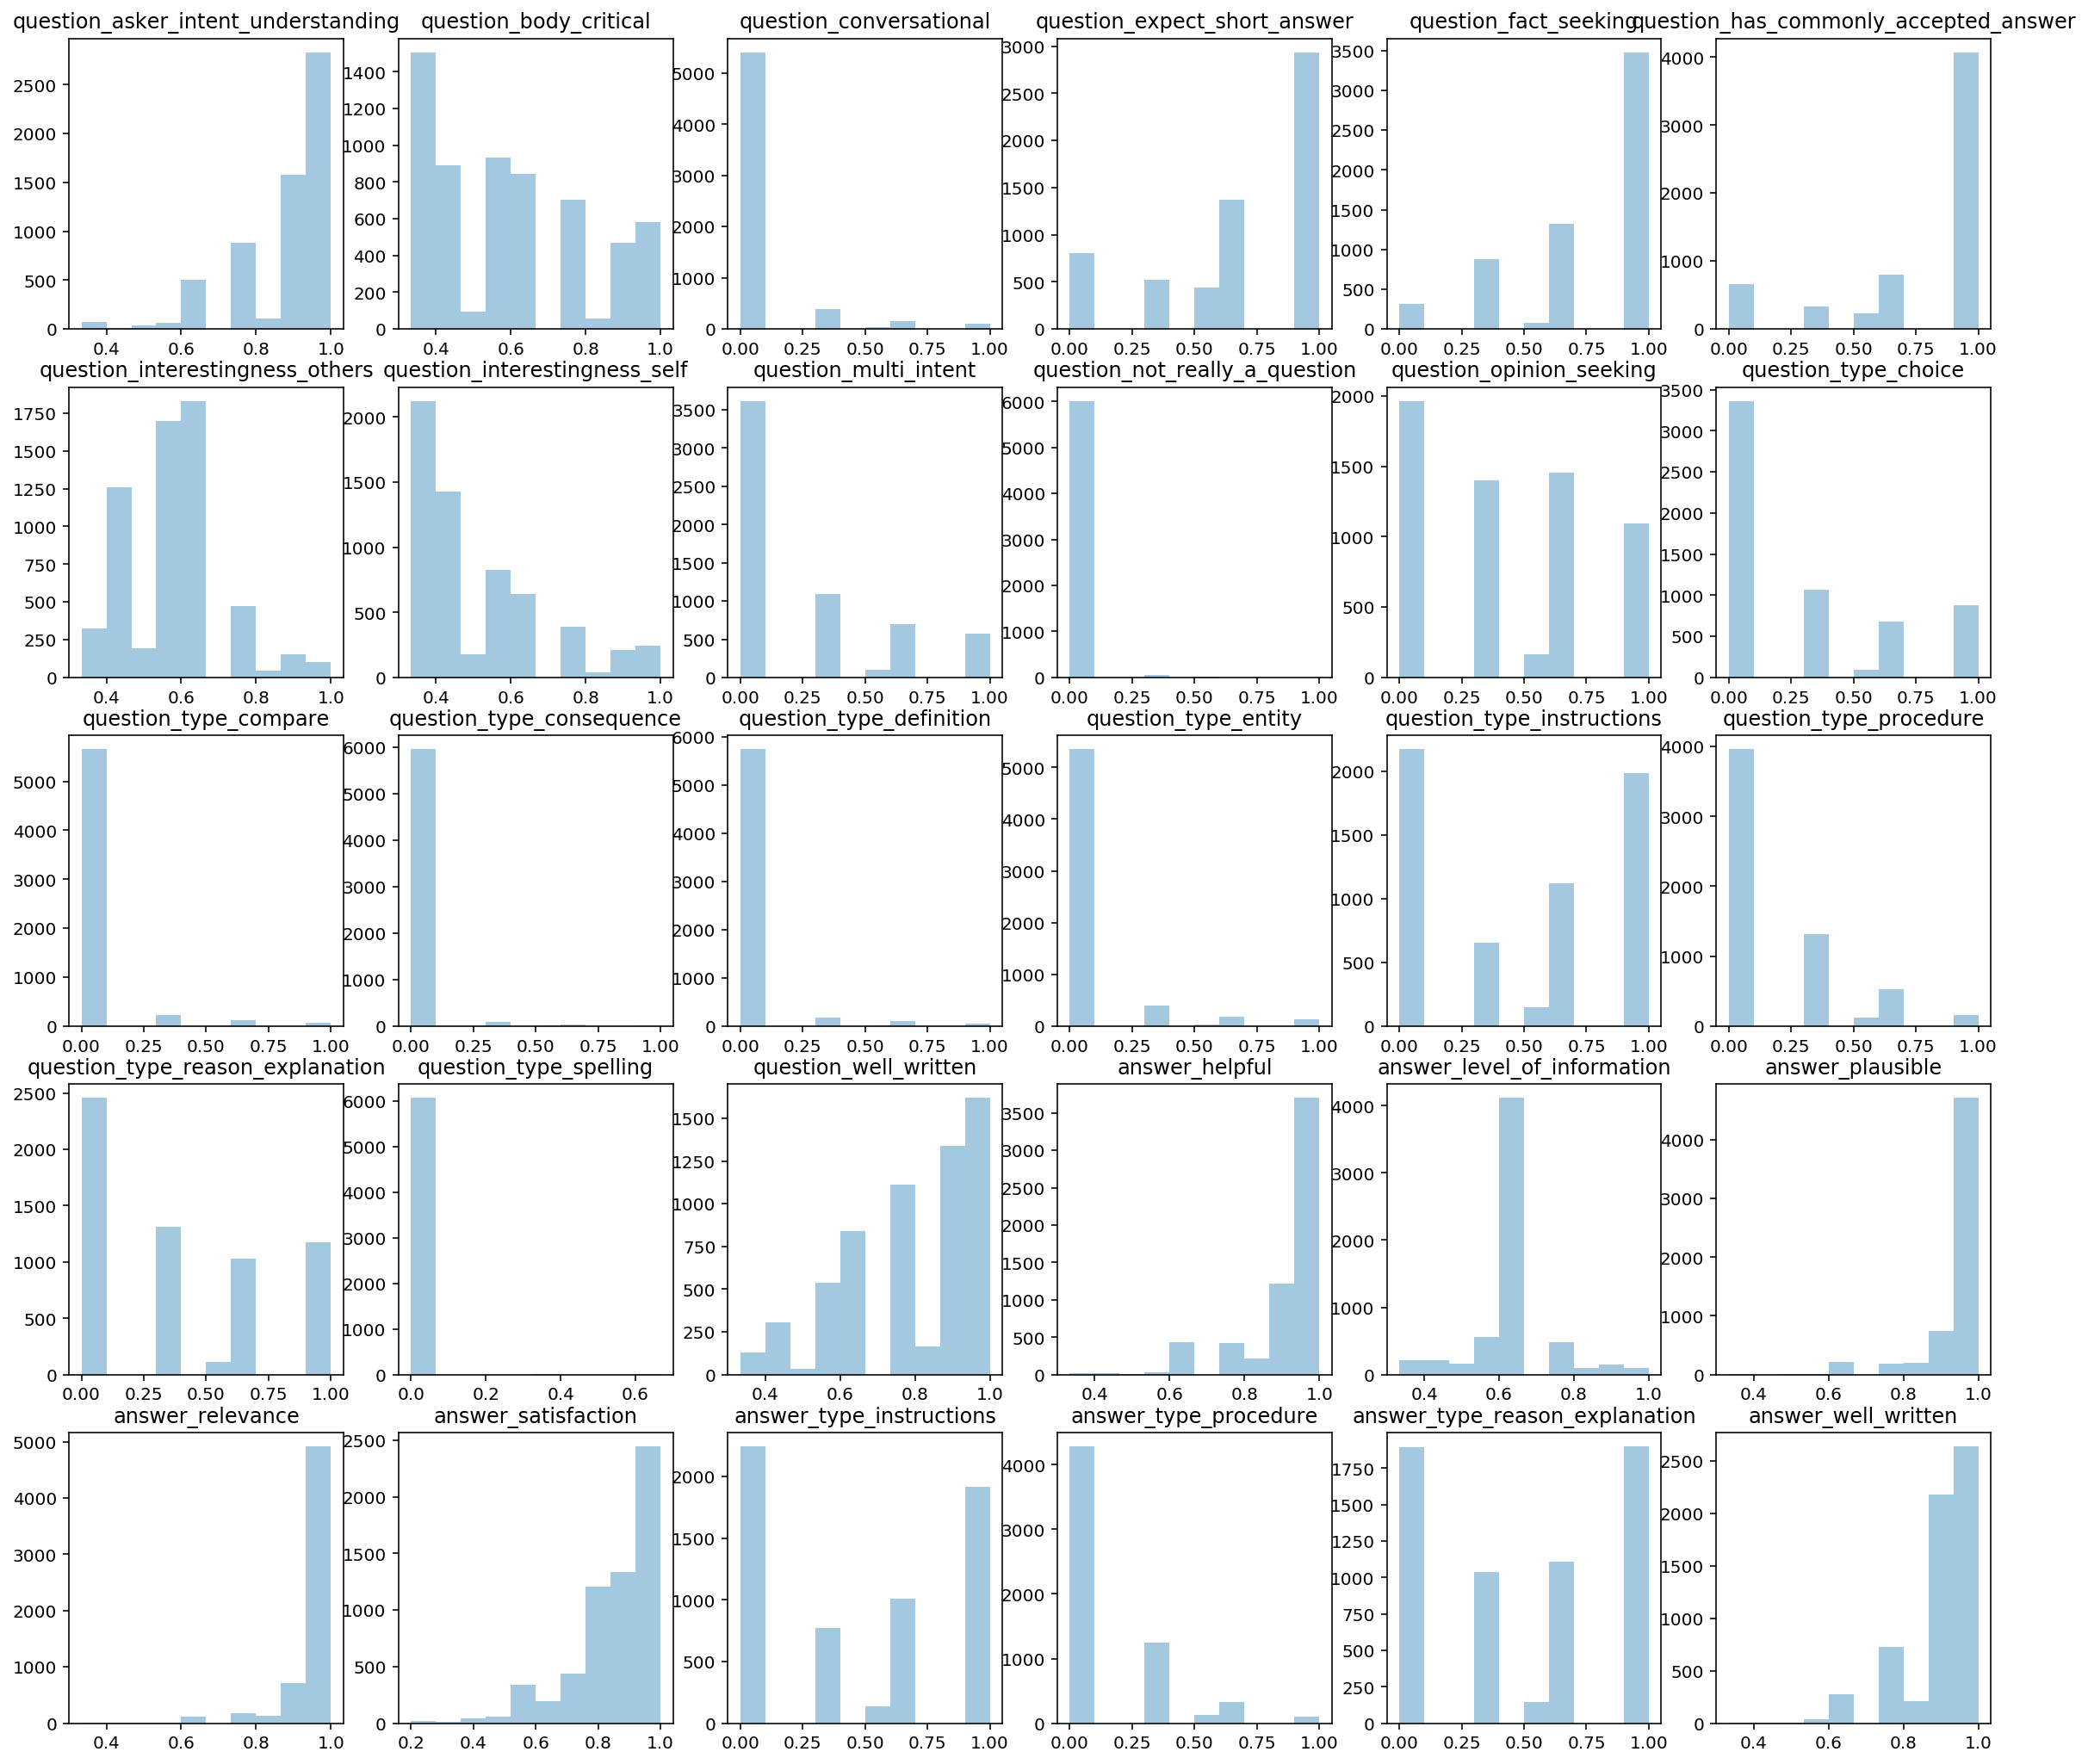

In [15]:
fig, axs = plt.subplots(5, 6, figsize=(20, 18))

for col, ax in zip(label_cols, axs.flatten()):
    ax.hist(trn_df[col], alpha=0.4)
    ax.set_title(f'{col}')
plt.show()

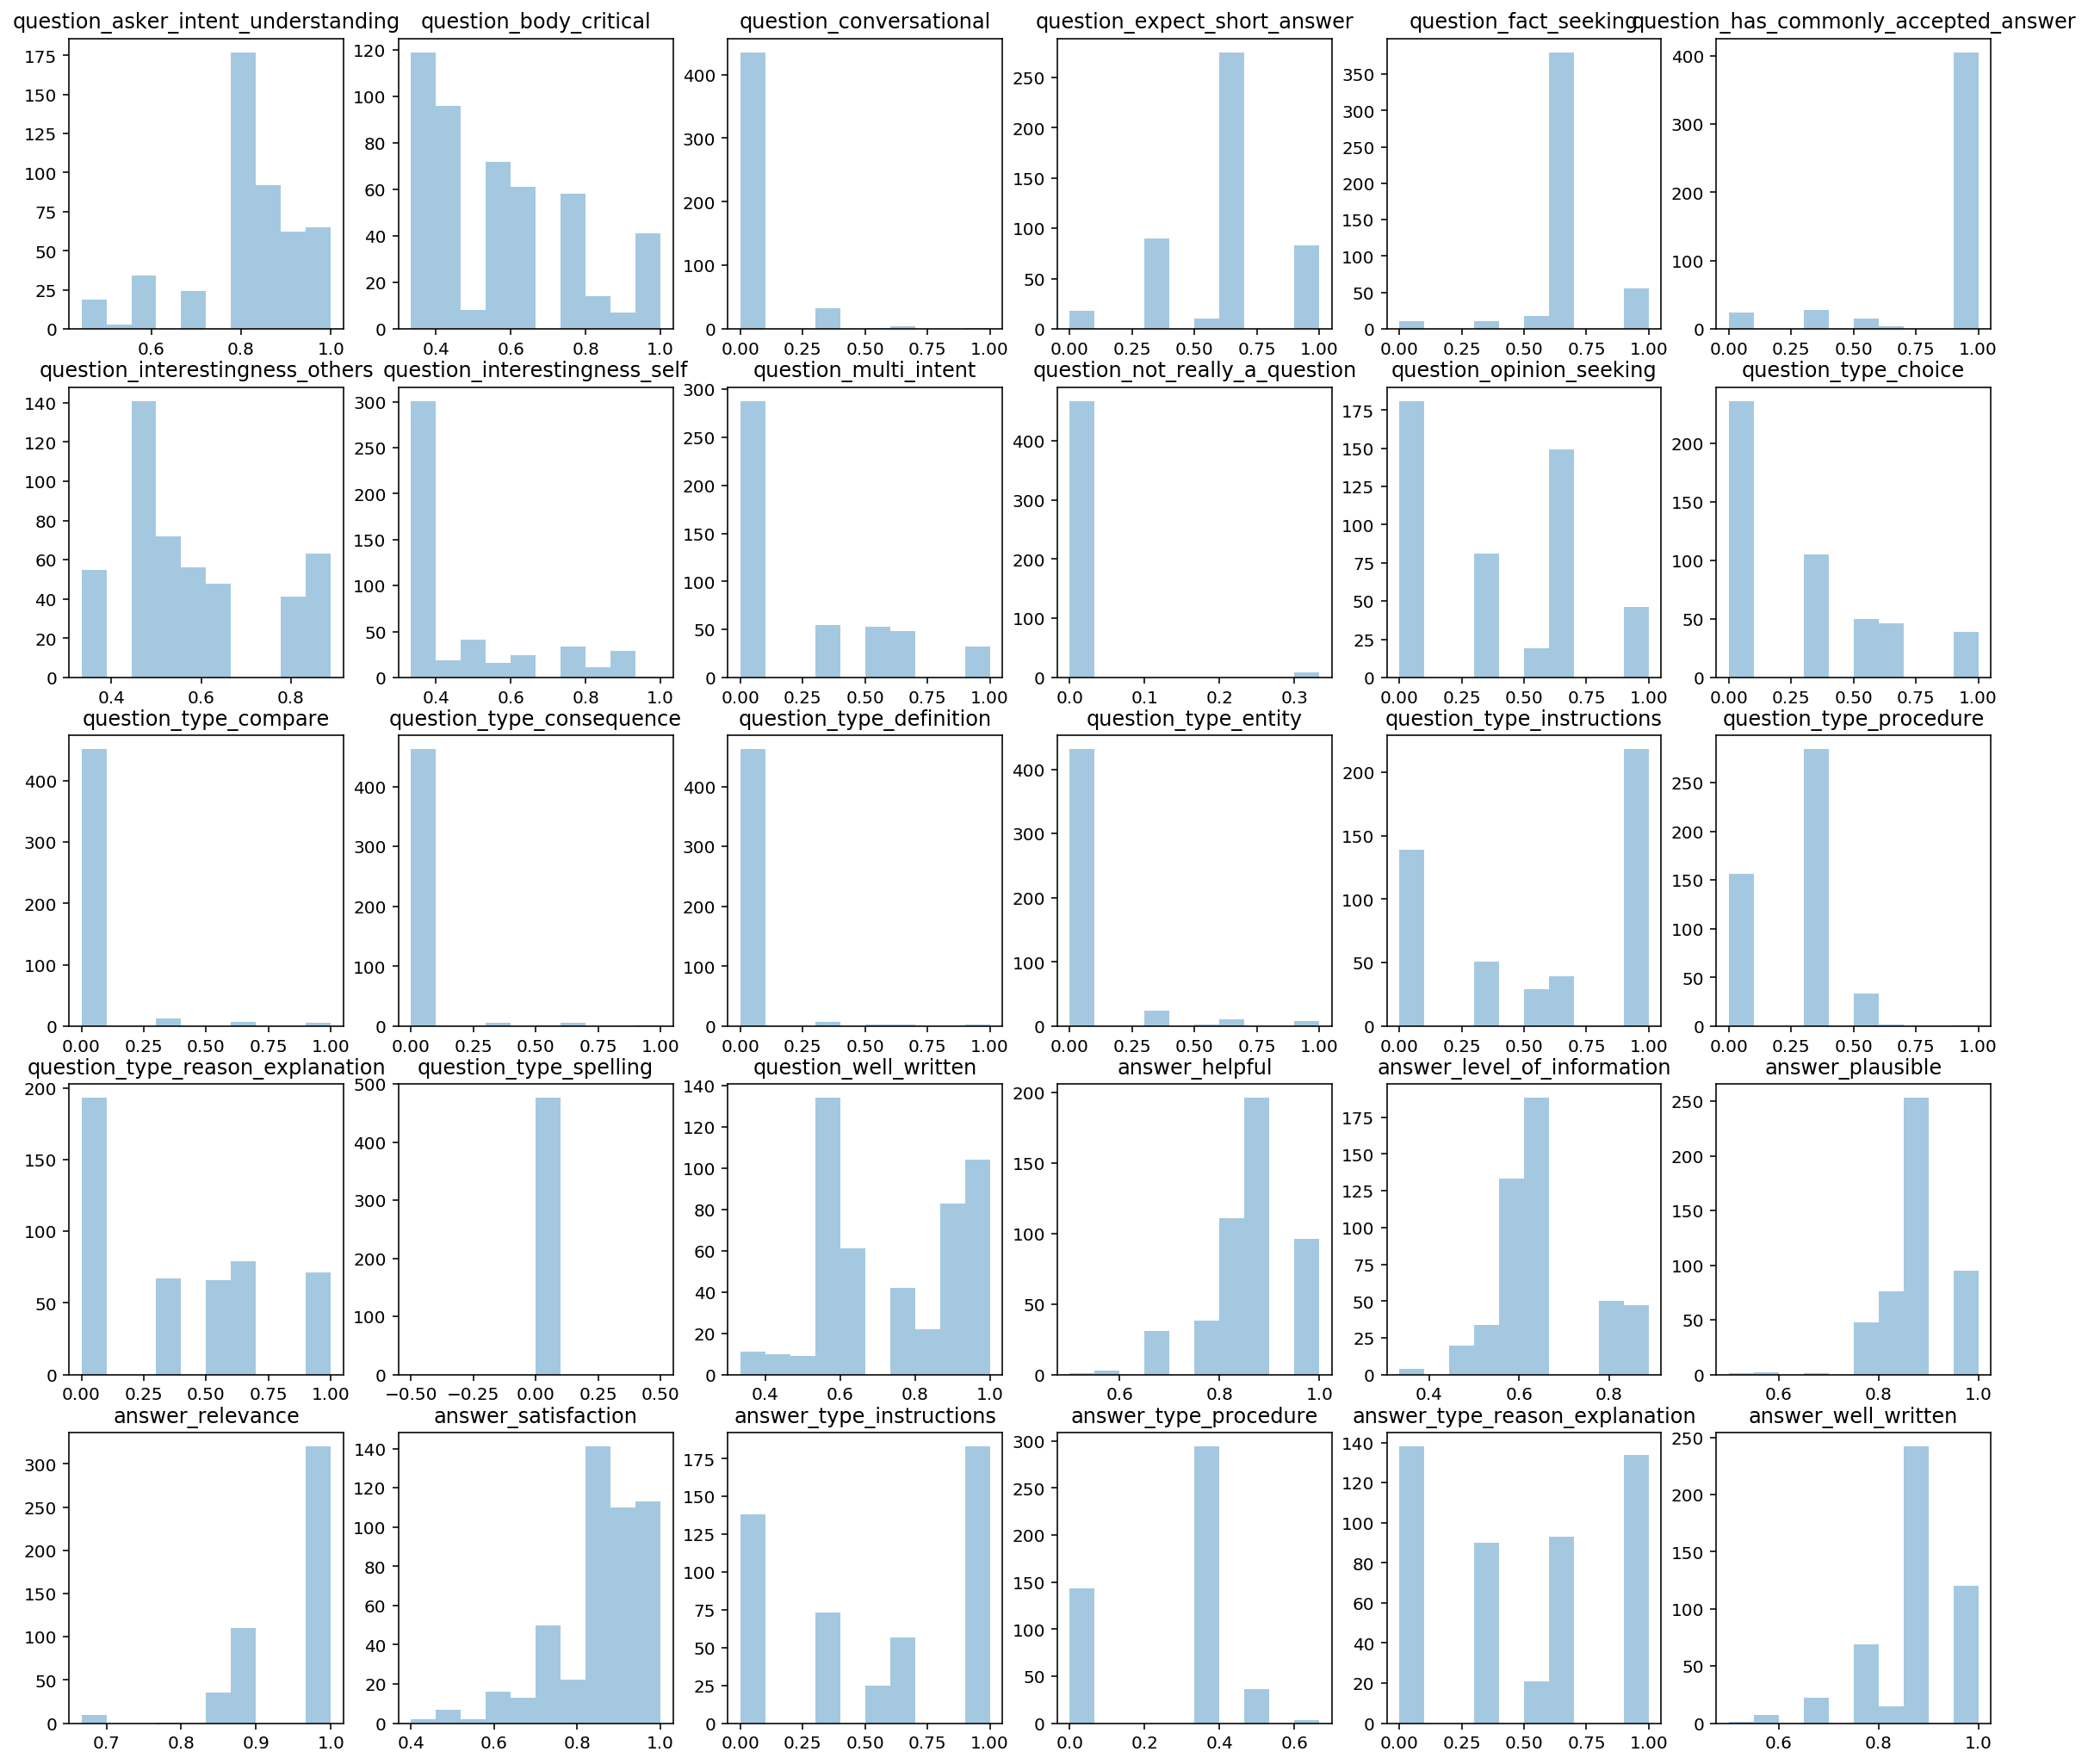

In [19]:
fig, axs = plt.subplots(5, 6, figsize=(20, 18))

for col, ax in zip(label_cols, axs.flatten()):
    ax.hist(opt_preds_df[col], alpha=0.4)
    ax.set_title(f'{col}')
plt.show()

## check values

In [31]:
CKPT_DIR = '../mnt/checkpoints'

with open(f'{CKPT_DIR}/e078/snapshot_dicts.pkl', 'rb') as fin:
    bert_question_dict = pickle.load(fin)
with open(f'{CKPT_DIR}/e079/snapshot_dicts.pkl', 'rb') as fin:
    bert_answer_dict = pickle.load(fin)
    
with open(f'{CKPT_DIR}/e080/snapshot_dicts.pkl', 'rb') as fin:
    roberta_question_dict = pickle.load(fin)
with open(f'{CKPT_DIR}/e081/snapshot_dicts.pkl', 'rb') as fin:
    roberta_answer_dict = pickle.load(fin)
    
# with open(f'{CKPT_DIR}/e072/snapshot_dicts.pkl', 'rb') as fin:
#     gpt2_question_dict = pickle.load(fin)
# with open(f'{CKPT_DIR}/e073/snapshot_dicts.pkl', 'rb') as fin:
#     gpt2_answer_dict = pickle.load(fin)
    
with open(f'{CKPT_DIR}/e082/snapshot_dicts.pkl', 'rb') as fin:
    xlnet_question_dict = pickle.load(fin)
with open(f'{CKPT_DIR}/e083/snapshot_dicts.pkl', 'rb') as fin:
    xlnet_answer_dict = pickle.load(fin)

In [47]:
col_idx = 19

col_y_preds = []
col_y_trues = []

for i in range(5):
    col_y_preds.append(bert_question_dict[i]['y_preds'][0][:, col_idx])
    col_y_trues.append(bert_question_dict[i]['y_trues'][0][:, col_idx])

In [48]:
col_y_pred = np.concatenate(col_y_preds)
col_y_true = np.concatenate(col_y_trues)

In [49]:
spearmanr(col_y_true, col_y_pred)

SpearmanrResult(correlation=0.06318632013124197, pvalue=8.205249354495211e-07)

In [86]:
# n = trn_df['url'].apply(lambda x:('english.stackexchange.com' in x)).tolist()
# n = trn_df['host'].isin(['english.stackexchange.com', 'ell.stackexchange.com']).tolist()
n = (trn_df['host'].isin(['english.stackexchange.com', 'ell.stackexchange.com']).values & (trn_df['category'] == 'CULTURE').values).tolist()
spelling=[]
for x in n:
    if x:
        spelling.append(0.5)
    else:
        spelling.append(0.)

In [79]:
spearmanr(trn_df['question_type_spelling'].values, spelling)

SpearmanrResult(correlation=0.17452755624517122, pvalue=8.833301429919017e-43)

In [81]:
spearmanr(trn_df['question_type_spelling'].values, spelling)

SpearmanrResult(correlation=0.18243502623664384, pvalue=1.2012704859255746e-46)

In [85]:
spearmanr(trn_df['question_type_spelling'].values, spelling)

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SpearmanrResult(correlation=nan, pvalue=nan)

## analysis about question_type_spelling

In [53]:
analysis_col = 'question_type_spelling'

In [60]:
analysis_df = trn_df.query('question_type_spelling > 0')
analysis_df

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
362,572,"""Hirable"" or ""hireable""",What is the correct adjective form of the word...,Greg Bray,https://english.stackexchange.com/users/9063,This is starting to become a bit of a hoary ol...,FumbleFingers,https://english.stackexchange.com/users/2637,http://english.stackexchange.com/questions/269...,CULTURE,english.stackexchange.com,1.0,0.666667,0.000000,1.000000,0.666667,1.000000,0.666667,0.555556,0.000000,0.0,0.333333,0.333333,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.666667,0.666667,0.888889,0.666667,1.000000,1.000000,0.866667,0.000000,0.000000,0.666667,1.000000
700,1106,Are there /ɔ/ and /ʌ/ sounds in informal Ameri...,I read a book about American English. It repor...,Kas,https://english.stackexchange.com/users/10792,The /ɔ/ as described by Wikipedia is an unelis...,KeithS,https://english.stackexchange.com/users/9887,http://english.stackexchange.com/questions/333...,CULTURE,english.stackexchange.com,1.0,0.444444,0.000000,0.666667,1.000000,1.000000,0.555556,0.666667,1.000000,0.0,0.333333,1.000000,0.000000,0.0,0.000000,0.0,0.333333,0.333333,1.000000,0.333333,0.777778,1.000000,0.777778,0.888889,0.888889,0.800000,0.000000,0.333333,1.000000,0.888889
930,1468,"It was a tough question. I thought it through,...","Is there a rule, or rules, for how to pronounc...",JimM,https://ell.stackexchange.com/users/11894,"There isn't a rule, really. English is known f...",Sander,https://ell.stackexchange.com/users/19983,http://ell.stackexchange.com/questions/58002/i...,CULTURE,ell.stackexchange.com,1.0,1.000000,0.000000,0.333333,1.000000,1.000000,0.666667,0.666667,0.333333,0.0,0.000000,0.333333,0.000000,0.0,0.666667,0.0,0.000000,0.000000,0.333333,0.666667,0.888889,0.777778,0.666667,0.777778,1.000000,0.933333,0.000000,0.000000,0.333333,1.000000
1259,1984,"What's the correct pronunciation of ""epitome"":...",A friend said that epitome is pronounced as ep...,Lelouch Lamperouge,https://english.stackexchange.com/users/7547,"As reported by the NOAD and the OED, Epitome i...",kiamlaluno,https://english.stackexchange.com/users/252,http://english.stackexchange.com/questions/220...,CULTURE,english.stackexchange.com,1.0,0.666667,0.000000,1.000000,1.000000,1.000000,0.666667,0.777778,0.666667,0.0,0.333333,0.333333,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.666667,0.333333,1.000000,0.888889,0.555556,1.000000,1.000000,0.866667,0.000000,0.000000,0.666667,1.000000
1561,2449,"Any connection between akimbo, askance and atr...",I came across akimbo and askance today and won...,Mynamite,https://english.stackexchange.com/users/33153,This is actually a matter of general reference...,tchrist,https://english.stackexchange.com/users/2085,http://english.stackexchange.com/questions/111...,CULTURE,english.stackexchange.com,1.0,0.555556,0.000000,0.333333,1.000000,1.000000,0.666667,0.555556,0.666667,0.0,0.000000,1.000000,0.333333,0.0,0.333333,0.0,0.000000,0.000000,1.000000,0.333333,1.000000,0.888889,0.888889,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
1628,2552,"What's the correct pronunciation of ""epitome"":...",A friend said that epitome is pronounced as ep...,Lelouch

In [96]:
analysis_df.iloc[:, :11]

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
362,572,"""Hirable"" or ""hireable""",What is the correct adjective form of the word...,Greg Bray,https://english.stackexchange.com/users/9063,This is starting to become a bit of a hoary ol...,FumbleFingers,https://english.stackexchange.com/users/2637,http://english.stackexchange.com/questions/269...,CULTURE,english.stackexchange.com
700,1106,Are there /ɔ/ and /ʌ/ sounds in informal Ameri...,I read a book about American English. It repor...,Kas,https://english.stackexchange.com/users/10792,The /ɔ/ as described by Wikipedia is an unelis...,KeithS,https://english.stackexchange.com/users/9887,http://english.stackexchange.com/questions/333...,CULTURE,english.stackexchange.com
930,1468,"It was a tough question. I thought it through,...","Is there a rule, or rules, for how to pronounc...",JimM,https://ell.stackexchange.com/users/11894,"There isn't a rule, really. English is known f...",Sander,https://ell.stackexchange.com/users/19983,http://ell.stackexchange.com/questions/58002/i...,CULTURE,ell.stackexchange.com
1259,1984,"What's the correct pronunciation of ""epitome"":...",A friend said that epitome is pronounced as ep...,Lelouch Lamperouge,https://english.stackexchange.com/users/7547,"As reported by the NOAD and the OED, Epitome i...",kiamlaluno,https://english.stackexchange.com/users/252,http://english.stackexchange.com/questions/220...,CULTURE,english.stackexchange.com
1561,2449,"Any connection between akimbo, askance and atr...",I came across akimbo and askance today and won...,Mynamite,https://english.stackexchange.com/users/33153,This is actually a matter of general reference...,tchrist,https://english.stackexchange.com/users/2085,http://english.stackexchange.com/questions/111...,CULTURE,english.stackexchange.com
1628,2552,"What's the correct pronunciation of ""epitome"":...",A friend said that epitome is pronounced as ep...,Lelouch Lamperouge,https://english.stackexchange.com/users/7547,Epitome comes from Greek but it was introduced...,Alain Pannetier Φ,https://english.stackexchange.com/users/5432,http://english.stackexchange.com/questions/220...,CULTURE,english.stackexchange.com
1646,2590,Is there a schwa in the middle of Coleridge?,How many syllables are in the name Coleridge -...,WAF,https://english.stackexchange.com/users/2396,"From Coleridge himself, we have\n\n\n Parry s...",Peter Shor,https://english.stackexchange.com/users/5754,http://english.stackexchange.com/questions/307...,CULTURE,english.stackexchange.com
2591,4121,Are there /ɔ/ and /ʌ/ sounds in informal Ameri...,I read a book about American English. It repor...,Kas,https://english.stackexchange.com/users/10792,Standard English has all of the sounds you men...,Kosmonaut,https://english.stackexchange.com/users/449,http://english.stackexchange.com/questions/333...,CULTURE,english.stackexchange.com
3323,5305,It was a pun! from the Dead parrot sketch,In Monty Python's Dead parrot sketch when John...,xaxa,https://ell.stackexchange.com/users/3494,Here is the dialogue I found. (source) In the ...,Damkerng T.,https://ell.stackexchange.com/users/3281,http://ell.stackexchange.com/questions/14327/i...,CULTURE,ell.stackexchange.com
3579,5719,"Do Americans pronounce ""Ellen"" and ""Alan"" in t...","Do Americans pronounce ""Ellen"" and ""Alan"" in t...",brilliant,https://english.stackexchange.com/users/2270,Ellen /ɛlən/ (with variant Helen) is pronounce...,Mark Beadles,https://english.stackexchange.com/users/16191,http://english.stackexchange.com/questions/642...,CULTURE,english.stackexchange.com


In [95]:
analysis_df.iloc[:, 11:].corr('spearman').iloc[19:20]

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
question_type_spelling,NaN,0.121757,-0.239046,0.198206,-0.088641,-0.177281,0.660687,0.0,-0.314178,NaN,-0.132137,-0.310304,-0.239046,NaN,0.038145,NaN,-0.239046,-0.239046,-0.496486,1.0,-0.34302,0.0,-0.155152,-0.038145,0.46291,-0.123219,-0.239046,-0.239046,-0.571291,0.457738


In [94]:
trn_df.iloc[:, 11:].corr('spearman').iloc[19:20]

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
question_type_spelling,0.042034,0.011993,-0.002,0.008826,0.020496,0.012939,0.002373,0.038137,0.021326,-0.004461,-0.02208,0.03384,0.002921,-0.006318,0.039229,-0.015706,-0.046383,-0.023589,0.006852,1.0,0.010781,-0.009531,0.033334,-0.003959,-0.006497,0.001508,-0.042868,-0.019614,0.02027,0.019892


In [57]:
trn_df.host.value_counts().loc[['english.stackexchange.com', 'ell.stackexchange.com']]

english.stackexchange.com    229
ell.stackexchange.com         85
Name: host, dtype: int64

In [58]:
tst_df.host.value_counts().loc[['english.stackexchange.com', 'ell.stackexchange.com']]

english.stackexchange.com    7
ell.stackexchange.com        4
Name: host, dtype: int64

In [59]:
a = trn_df.query('question_type_spelling > 0')
pd.crosstab(a.host, a[analysis_col])

question_type_spelling,0.333333,0.666667
host,,
ell.stackexchange.com,1,1
english.stackexchange.com,6,3


In [63]:
for i, row in analysis_df.iterrows():
    print('===========', row[analysis_col], row['host'], '===========')
    print(' --- title ---')
    print(row.question_title)
    print(' --- body ---')
    print(row.question_body)

=========== 0.6666666666666666 english.stackexchange.com ===========
 --- title ---
"Hirable" or "hireable"
 --- body ---
What is the correct adjective form of the word hire? I have seen references to both hireable and hirable. 

I checked using Google's Ngram viewer book search and it appears that both have been in use since the 1800s with hirable becoming a bit more popular in the past decade or so:



=========== 0.3333333333333333 english.stackexchange.com ===========
 --- title ---
Are there /ɔ/ and /ʌ/ sounds in informal American English?
 --- body ---
I read a book about American English. It reports that, in standard informal conversations, American English doesn't use the /ɔ/ sound; it uses the /ɑ/ sound and /ʌ/ and /ə/ are not different. Are they really?
That book would not use the /ɔ/ and /ʌ/ sounds, but when I look in my American English Dictionary for some words, such as more, door, and love, they are reported to be pronounced /mɔr/, /dɔr/, and /lʌv/.
How should I pronounce

In [71]:
trn_df[trn_df.question_body.str.contains('adjective')][analysis_col]

171     0.000000
362     0.666667
592     0.000000
1061    0.000000
1480    0.000000
2871    0.000000
2909    0.000000
3386    0.000000
3944    0.000000
3998    0.000000
4082    0.333333
Name: question_type_spelling, dtype: float64

In [70]:
tst_df[tst_df.question_body.str.contains('pronounce')]

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host


In [89]:
tst_df[tst_df.host.isin(['english.stackexchange.com', 'ell.stackexchange.com'])].category

42     CULTURE
107    CULTURE
114    CULTURE
171    CULTURE
184    CULTURE
207    CULTURE
278    CULTURE
348    CULTURE
360    CULTURE
369    CULTURE
424    CULTURE
Name: category, dtype: object

## analysis about question_not_really_a_question

In [136]:
analysis_col = 'question_not_really_a_question'

In [135]:
trn_df[['qa_id', 'question_title', 'question_body', 'question_user_name', 'question_user_page', 'answer', 'answer_user_name', 'answer_user_page', 'url', 'category', 'host', analysis_col]].head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_type_compare
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,0.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,0.666667
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.000000
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,0.000000


In [137]:
analysis_df = trn_df.query(f'{analysis_col} > 0')
analysis_df[['qa_id', 'question_title', 'question_body', 'question_user_name', 'question_user_page', 'answer', 'answer_user_name', 'answer_user_page', 'url', 'category', 'host', analysis_col]]

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_not_really_a_question
121,192,Undelete comment on a Facebook Page,The new Facebook Page Manager app (in combinat...,batpigandme,https://webapps.stackexchange.com/users/36671,"No, there is no way to retrieve a deleted comm...",phwd,https://webapps.stackexchange.com/users/40,http://webapps.stackexchange.com/questions/442...,TECHNOLOGY,webapps.stackexchange.com,0.333333
139,222,Apps are not permitted to access the UDID,I am facing this issue while submitting the ap...,Shekhar Gupta,https://stackoverflow.com/users/1716239,"UDID is deprecated, and it's use is no longer ...",Woodstock,https://stackoverflow.com/users/1784011,http://stackoverflow.com/questions/18785321/ap...,STACKOVERFLOW,stackoverflow.com,0.333333
220,352,Generating all keypad possibilities,I ran into this question on Stack Overflow. It...,Pinoniq,https://codereview.stackexchange.com/users/26276,"Overall, I'd say recursion is a good way to go...",Flambino,https://codereview.stackexchange.com/users/14370,http://codereview.stackexchange.com/questions/...,TECHNOLOGY,codereview.stackexchange.com,0.333333
336,536,"C# & VS error: ""make sure that the maximum ind...",I faced the error mentioned in the title when ...,user2884188,https://stackoverflow.com/users/2884188,"Notice that when you define an array, range of...",pooria haddad,https://stackoverflow.com/users/2751916,http://stackoverflow.com/questions/19391293/c-...,STACKOVERFLOW,stackoverflow.com,0.333333
380,598,Wordpress and isotope filtering,Im trying to use Isotope(http://isotope.metafi...,dinosauuur,https://wordpress.stackexchange.com/users/13960,Add the animationEngnine: 'jquery' - and the a...,Justin Young,https://wordpress.stackexchange.com/users/27394,http://wordpress.stackexchange.com/questions/4...,TECHNOLOGY,wordpress.stackexchange.com,0.500000
781,1242,Layman's guide to getting started with Forex (...,How should I get started with Forex (foreign e...,harvardfail,https://money.stackexchange.com/users/4311,"Currency Trading For Dummies, no offense. The ...",JoeTaxpayer,https://money.stackexchange.com/users/187,http://money.stackexchange.com/questions/12446...,LIFE_ARTS,money.stackexchange.com,0.333333
843,1341,Understanding the definition of the order of a...,Let $f: \mathbb C \to \mathbb C$ be an entire ...,user1337,https://math.stackexchange.com/users/62839,Note that\n\n$$F(\rho) = \sup_{r \geqslant \rh...,Daniel Fischer,https://math.stackexchange.com/users/83702,http://math.stackexchange.com/questions/475408...,SCIENCE,math.stackexchange.com,0.333333
917,1453,Quicklook is broken in Lion,[Turns out this is known bug #9536151]\n\nI ha...,Gazzer,https://apple.stackexchange.com/users/9876,You might see a message in the console like th...,David DelMonte,https://apple.stackexchange.com/users/11128,http://apple.stackexchange.com/questions/33448...,TECHNOLOGY,apple.stackexchange.com,0.333333
988,1563,"Silent, extremely portable instrument to learn...",I am currently off work for more or less a mon...,Pal Lito,https://music.stackexchange.com/users/3098,This may just be my opinion but I don't think ...,Dr Mayhem,https://music.stackexchange.com/users/104,http://music.stackexchange.com/questions/7615/...,LIFE_ARTS,music.stackexchange.com,0.333333
1222,1917,Bake particle system animation and delete few ...,I want to delete few particles from particle s...,wyy,https://blender.stackexchange.com/users/1751,The only way I know to edit already emitted pa...,stacker,https://blender.stackexchange.com/users/29,http://blender.stackexchange.com/questions/588...,TECHNOLOGY,blender.stackexchange.com,0.333333


In [102]:
for i, row in analysis_df.iterrows():
    print('===========', row[analysis_col], row['host'], '===========')
    print(' --- title ---')
    print(row.question_title)
    print(' --- body ---')
    print(row.question_body)
    print(' --- answer ---')
    print(row.answer)

=========== 0.3333333333333333 webapps.stackexchange.com ===========
 --- title ---
Undelete comment on a Facebook Page
 --- body ---
The new Facebook Page Manager app (in combination with my less than stellar thumb accuracy) has had me inadvertently deleting comments (when I've been trying to like them) left and right. Is there any way to undo this?

If not, is there any way to tag a person who is a fan of the page and who commented on the post/picture but whose comment you deleted? I assume the answer is no since you cannot (acting as a page) tag someone in a reply who has not yet commented on a given post, but didn't know if anyone knew of any workarounds...

 --- answer ---
No, there is no way to retrieve a deleted comment. Additionally, the rest of what you said is true, you will not be able to tag this person in the reply.

=========== 0.3333333333333333 stackoverflow.com ===========
 --- title ---
Apps are not permitted to access the UDID
 --- body ---
I am facing this issue whi

In [103]:
for i, row in trn_df.sample(20).iterrows():
    print('===========', row[analysis_col], row['host'], '===========')
    print(' --- title ---')
    print(row.question_title)
    print(' --- body ---')
    print(row.question_body)
    print(' --- answer ---')
    print(row.answer)

=========== 0.0 superuser.com ===========
 --- title ---
bash script to sort out duplicates in text file
 --- body ---
I converted all the flac in my music library down to mp3, so I can move the flac to an external drive. I used dbpoweramp in windows, and I'm pretty sure it converted them all, but when I woke up this morning, the netbook had been restarted.

So I've made a list with all my music in it and used sort to alphabetize it. So I have something like this:

~/music/a/a.flac
~/music/a/a.mp3
~/music/a/b.flac
~/music/a/b.mp3
~/music/b/a.mp3
~/music/b/b.mp3
~/music/c/a.flac
~/music/c/a.mp3


Note that I have a directory with only mp3, since not my whole library was flac.

What I want is a bash script that will check that all lines that end with .flac have a line directly below them that is the same except it ends with .mp3.

How would I achieve this, and if you can explain what the script is doing, that would be cool too.

I guess it's sorta important to show any lines that end wit

In [146]:
for q_word in ["Can", "Could", "Did", "Does", "Do", "Has", "How", "Will", "Is", "What", "Where", "Why", "When", "What", ]:
    analysis_df[f'{q_word}_q_word'] = analysis_df.question_title.str.contains(q_word).values & \
                                                                    analysis_df.question_body.str.contains(q_word).values & \
                                                                    analysis_df.answer.str.contains(q_word).values

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
analysis_df[analysis_df.columns[analysis_df.columns.str.contains('q_word')]].sum(axis=1)

## analysis about question_type_compare
 - 何かを比較している？
     - between とか among とか入ってたらこれに当たる？
     - answer に best とか better とか入ってたらそれっぽい？

In [114]:
analysis_col = 'question_type_compare'

In [115]:
analysis_df = trn_df.query(f'{analysis_col} > 0')
analysis_df[['qa_id', 'question_title', 'question_body', 'question_user_name', 'question_user_page', 'answer', 'answer_user_name', 'answer_user_page', 'url', 'category', 'host', analysis_col]]

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_type_compare
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,0.666667
13,17,what's the relation between sensor size and im...,I'm reading this description on sensor size:\n...,cody,https://photo.stackexchange.com/users/11005,A digital image sensor is ultimately a device ...,jrista,https://photo.stackexchange.com/users/124,http://photo.stackexchange.com/questions/26001...,LIFE_ARTS,photo.stackexchange.com,0.333333
22,30,"2 servers, high availability and faster response",I recently bought a second webserver because I...,user17886,https://serverfault.com/users/133018,We do it on all our customer HA boxes and our ...,Ben Lessani - Sonassi,https://serverfault.com/users/113375,http://serverfault.com/questions/430759,TECHNOLOGY,serverfault.com,0.333333
39,59,Difference between busses,I think I am confusing the difference between ...,rubixibuc,https://electronics.stackexchange.com/users/7163,The interrelationship of the different busses ...,Majenko,https://electronics.stackexchange.com/users/4245,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,1.000000
55,82,"What are the disadvantages of ""puncture proof""...",Some people refer to tires that are more resis...,b.roth,https://bicycles.stackexchange.com/users/131,The obvious advantage is puncture resistance\n...,Paparazzi,https://bicycles.stackexchange.com/users/7785,http://bicycles.stackexchange.com/questions/24...,CULTURE,bicycles.stackexchange.com,1.000000
82,135,"What's a better method, using Large Array vs S...",I can't decide on w/c technique to go w/... al...,BrownChiLD,https://stackoverflow.com/users/1797947,"It sounds as if you've decided how to proceed,...",Jared Farrish,https://stackoverflow.com/users/451969,http://stackoverflow.com/questions/15719986/wh...,STACKOVERFLOW,stackoverflow.com,0.666667
84,139,I want to build a portable railgun and I'm a c...,I'd like to enter the world of electronic hobb...,lychnus,https://electronics.stackexchange.com/users/23933,A 10g projectile moving at 100m/s has a kineti...,pjc50,https://electronics.stackexchange.com/users/2228,http://electronics.stackexchange.com/questions...,TECHNOLOGY,electronics.stackexchange.com,0.333333
104,170,"Is it better to put ""Preview"" on an iFrame wit...",We have a page that shows a preview of another...,catandmouse,https://ux.stackexchange.com/users/7021,It sounds like you are describing every help w...,Brian Blain,https://ux.stackexchange.com/users/33273,http://ux.stackexchange.com/questions/41685/is...,TECHNOLOGY,ux.stackexchange.com,0.666667
129,204,What is the best way for a user to select an i...,My team and I are building a mobile app where ...,Nick Saunders,https://ux.stackexchange.com/users/50391,We provide retail and stock control systems so...,rlb,https://ux.stackexchange.com/users/35356,http://ux.stackexchange.com/questions/77187/wh...,TECHNOLOGY,ux.stackexchange.com,0.333333
135,215,What are the uses for a roasting pan? Do I rea...,We registered for a roasting pan and it has be...,milesmeow,https://cooking.stackexchange.com/users/2125,I use my roasting pan (either with or without ...,KimbaF,https://cooking.stackexchange.com/users/2939,http://cooking.stackexchange.com/questions/860...,LIFE_ARTS,cooking.stackexchange.com,0.333333


In [108]:
for i, row in analysis_df.iterrows():
    print('===========', row[analysis_col], row['host'], '===========')
    print(' --- title ---')
    print(row.question_title)
    print(' --- body ---')
    print(row.question_body)
    print(' --- answer ---')
    print(row.answer)

=========== 0.6666666666666666 rpg.stackexchange.com ===========
 --- title ---
What is the distinction between a city and a sprawl/metroplex... between downtown and a commercial district?
 --- body ---
I am trying to understand what kinds of places the spam values on p 231 refer to in the 5th Edition main book for Shadowrun.

Per p 15, a sprawl is a plex, a plex is a "metropolitan complex, short for metroplex". Per Google a metroplex is " a very large metropolitan area, especially one that is an aggregation of two or more cities".  A city downtown and sprawl downtown would tend to have similar densities, but for some reason the sprawl (which includes suburbs?) has a higher spam zone noise rating (p 231).  Similarly, I'd think of a downtown as being more dense and noisy (e.g. Office buildings and street vendors) than a commercial district, e.g. an outdoor mall.  The noise ratings make me think that I am thinking about this incorrectly. What is a better way of thinking of them?

 --- an

 --- answer ---
The main reason would be for power efficiency. The voltage regulator inside the chip is a linear one, which means that its efficiency is: (VDDCORE/VDDIO). So if your VDDIO is 3.6v, then your efficiency might be only 33%! This is a terrible waste of energy, especially in a battery powered portable device where a long battery life is an important selling point for the device.

Poor power efficiency not only leads to a shorter battery life, it also generates heat. In this case it doesn't seem like much, but it can make all the difference. In a hot environment, that extra heat might push the chip over its specified operating conditions, leading to failure. In some applications, you might have lots of chips, which could create quite a lot of heat. In one application, we had 20 ET1200 chips, all using their internal regulators. Each chip's core uses just 75mA. But 20 chips means 1.5A on the cores, and a total of 1.2W of power dissipated just as wasted heat. The inside of the 

=========== 0.3333333333333333 gis.stackexchange.com ===========
 --- title ---
Running ArcPy script from ArcObjects?
 --- body ---
the standard method requires to run ArcPy script in command line, i've struggled with it to run but without a result, i can import arcpy, set the workspace to the geodatabase path and describe the env variable using arcpy.Describe(arcpy.env.workspace).name it gives me the geodatabase name, but when i try to get featureclasses using arcpy.ListFeatureClasses() i get [], i have made sure that all the environement variables in PATH and PYTHONPATH are ok .

i would like to know if there's an alternative way to run ArcPy script, like it could be run in ArcMap console, is there a way to send scripts to ArcMap console using ArcObjects, what's the difference between ArcMap console and standard command line console?

so any way to run an ArcPy script using ArcObjects 10 or Arcgis Engine 10 will be very welcome.

 --- answer ---
There may be several options. If you p

 --- body ---
Now I know when it comes to electrolytic capacitors it's usually good practice to use a voltage rating 1.5x - 2.5x the maximum rating you ever expect the capacitor to be exposed to, as the lifetime can be significantly reduced by running it near its limits.

But does the same protocol apply to ceramic capacitors? For example, assume a 25V ceramic capacitor - will running it at 24V reduce its lifespan significantly?

I'm currently designing a PSU which needs to be reliable, so at the moment I'm using 50V caps for a maximum 20V input (35V caps aren't available), but I'd like to switch to 25V caps if possible.

 --- answer ---
You should actually not be comparing ceramics to electrolytics in terms of lifespan at all, they are actually intended for totally different purposes. Most beginners (I did untill recently) think they are just higher values, but they are as different as inductors are to resistors. Mainly because electrolytic values are more approximate, and their value

In [131]:
# q_relative_words = ['between', 'among', 'better', 'best']
q_relative_words = ['between', 'among', 'better', 'best']

for q_relative_word in q_relative_words:
    analysis_df[f'{q_relative_word}_question_has_relative_words'] = analysis_df.question_title.str.contains(q_relative_word).values | analysis_df.question_body.str.contains(q_relative_word).values | analysis_df.answer.str.contains(q_relative_word).values

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [132]:
analysis_df[analysis_df.columns[analysis_df.columns.str.contains('relative')]].sum(axis=1).value_counts()

1    188
0    163
2     60
3     16
dtype: int64

In [133]:
_analysis_df = trn_df.copy()

q_relative_words = ['between', 'among', 'better', 'best']

for q_relative_word in q_relative_words:
    _analysis_df[f'{q_relative_word}_question_has_relative_words'] = _analysis_df.question_title.str.contains(q_relative_word).values | _analysis_df.question_body.str.contains(q_relative_word).values | _analysis_df.answer.str.contains(q_relative_word).values
    
_analysis_df[_analysis_df.columns[_analysis_df.columns.str.contains('relative')]].sum(axis=1).value_counts()

0    4224
1    1505
2     297
3      52
4       1
dtype: int64

In [134]:
spearmanr(trn_df[analysis_col].values, _analysis_df[_analysis_df.columns[_analysis_df.columns.str.contains('relative')]].sum(axis=1).values)

SpearmanrResult(correlation=0.19805307986334128, pvalue=8.082570377324485e-55)

## analysis about question_type_consequence

In [109]:
analysis_col = 'question_type_consequence'

In [112]:
analysis_df = trn_df.query(f'{analysis_col} > 0')
analysis_df[['qa_id', 'question_title', 'question_body', 'question_user_name', 'question_user_page', 'answer', 'answer_user_name', 'answer_user_page', 'url', 'category', 'host', analysis_col]].sort_values(analysis_col)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_type_consequence
2733,4354,Kosher salt vs. Table salt for rib eye steak,I don't have any Kosher salt on hand and I'm c...,Archey,https://cooking.stackexchange.com/users/15419,The difference in salt is more related to how ...,EEP,https://cooking.stackexchange.com/users/15045,http://cooking.stackexchange.com/questions/303...,LIFE_ARTS,cooking.stackexchange.com,0.333333
2629,4178,LED as 230V AC indicator,Answers to other questions here (e.g. 1) show ...,RedGrittyBrick,https://electronics.stackexchange.com/users/2191,"As far as I can tell, Christmas tree LED light...",Phil Frost,https://electronics.stackexchange.com/users/17608,http://electronics.stackexchange.com/questions...,TECHNOLOGY,electronics.stackexchange.com,0.333333
2603,4142,Is it okay to vacuum a laptop keyboard?,Is it okay to vacuum a laptop keyboard? Would ...,dsafdsf,https://superuser.com/users/97559,"You can use vacuum cleaner, but make sure your...",Mehper C. Palavuzlar,https://superuser.com/users/13567,http://superuser.com/questions/334626,TECHNOLOGY,superuser.com,0.333333
2460,3923,Catalytic converter possibly bad. How soon do ...,2004 Cadillac SRX V8 AWD is making a rattling ...,Matt,https://mechanics.stackexchange.com/users/1581,It sounds as if the internals of the cat may h...,mikes,https://mechanics.stackexchange.com/users/1566,http://mechanics.stackexchange.com/questions/3...,SCIENCE,mechanics.stackexchange.com,0.333333
2451,3913,How valuable is studying cognitive psychology ...,I am starting my second year in grad school an...,JeroenEijkhof,https://ux.stackexchange.com/users/793,Have you studied cognitive psychology? Either ...,PhillipW,https://ux.stackexchange.com/users/4403,http://ux.stackexchange.com/questions/5534/how...,TECHNOLOGY,ux.stackexchange.com,0.333333
4487,7115,How does the colour of ambient lighting affect...,How does the colour of ambient lighting affect...,gjb,https://photo.stackexchange.com/users/3775,The issue with these sorts of light sources is...,mattdm,https://photo.stackexchange.com/users/1943,http://photo.stackexchange.com/questions/12053...,LIFE_ARTS,photo.stackexchange.com,0.333333
2306,3677,How do you decide when a paladin has fallen fr...,There does not seem to be a clear-cut way to d...,adclark09,https://rpg.stackexchange.com/users/22899,You're right. There is no clear cut way. Tha...,the dark wanderer,https://rpg.stackexchange.com/users/14848,http://rpg.stackexchange.com/questions/62167/h...,CULTURE,rpg.stackexchange.com,0.333333
4557,7219,Red flags of unpaid IT internship,I read the following question: Tips for a firs...,Armando,https://programmers.stackexchange.com/users/24962,Not an answer - but....\n\nUnless you are scor...,Martin Beckett,https://programmers.stackexchange.com/users/2021,http://programmers.stackexchange.com/questions...,TECHNOLOGY,programmers.stackexchange.com,0.333333
2053,3273,Should I always hibernate instead of shutting ...,I'm using Windows XP and I hate the long start...,Click Upvote,https://superuser.com/users/2641,"Under XP, the OS will slow down over time, and...",Phoshi,https://superuser.com/users/6998,http://superuser.com/questions/108791,TECHNOLOGY,superuser.com,0.333333
2631,4184,What do I do when a co-author takes too long t...,Two years ago I did a piece of research for a ...,Luana,https://academia.stackexchange.com/users/9512,It's inappropriate to submit a paper for publi...,Nate Eldredge,https://academia.stackexchange.com/users/1010,http://academia.stackexchange.com/questions/14...,LIFE_ARTS,academia.stackexchange.com,0.333333


In [113]:
pd.crosstab(
    analysis_df[analysis_col],
    analysis_df['host'],
)

host,academia.stackexchange.com,android.stackexchange.com,apple.stackexchange.com,askubuntu.com,bicycles.stackexchange.com,boardgames.stackexchange.com,chemistry.stackexchange.com,christianity.stackexchange.com,cooking.stackexchange.com,crypto.stackexchange.com,dba.stackexchange.com,diy.stackexchange.com,dsp.stackexchange.com,electronics.stackexchange.com,ell.stackexchange.com,gaming.stackexchange.com,judaism.stackexchange.com,math.stackexchange.com,mathoverflow.net,mechanics.stackexchange.com,money.stackexchange.com,movies.stackexchange.com,music.stackexchange.com,photo.stackexchange.com,physics.stackexchange.com,programmers.stackexchange.com,rpg.stackexchange.com,scifi.stackexchange.com,security.stackexchange.com,serverfault.com,stackoverflow.com,stats.stackexchange.com,superuser.com,tex.stackexchange.com,travel.stackexchange.com,ux.stackexchange.com,webmasters.stackexchange.com
question_type_consequence,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.333333,12,1,3,2,3,0,2,1,4,2,4,2,1,6,1,1,1,0,3,2,1,1,2,2,4,2,3,1,1,2,3,1,6,1,1,3,1
0.500000,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,0,0,0
0.666667,0,0,0,1,4,1,1,0,1,0,0,1,0,0,0,1,1,1,0,3,1,0,0,2,2,0,1,1,0,0,2,0,1,0,1,0,0
1.000000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,2,0,0,2,0,0,0,0,0,0


In [111]:
for i, row in analysis_df.iterrows():
    print('===========', row[analysis_col], row['host'], '===========')
    print(' --- title ---')
    print(row.question_title)
    print(' --- body ---')
    print(row.question_body)
    print(' --- answer ---')
    print(row.answer)

=========== 0.6666666666666666 bicycles.stackexchange.com ===========
 --- title ---
What are the disadvantages of "puncture proof" (or puncture resistant) tires?
 --- body ---
Some people refer to tires that are more resistant to punctures as "puncture proof" tires.
For example: Specialized All Condition Armadillo Tyre

Even though these tires are not really puncture proof, they do reduce a lot the chances of puncturing. So the advantage is obvious.

Apparently, they're not too expensive compared to regular tires. So, I was wondering why people would choose not to use these more resistant tires. What are their disadvantages?

 --- answer ---
The obvious advantage is puncture resistance

There are several disadvantages:


weight
rolling resistance
grip
ride
cost


There are several levels of puncture resistance and a Kevlar belt is not the only means.

Let me tell you a story.  After two years on a tire with moderate puncture resistance got my first flat and had to walk it home.  I got